## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [1]:
from class_LSST import LSST
from image_time_series import simulate_time_series_images
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


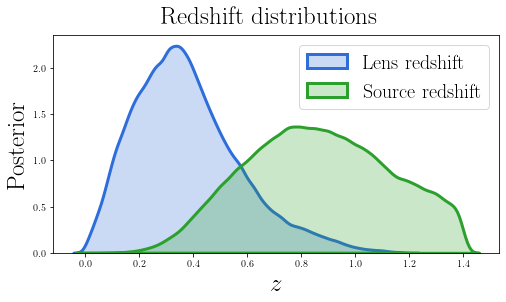

In [2]:
lsst = LSST(bandpass='i')

z_source_list_, z_lens_list_, theta_E_list_ = lsst.get_z_theta(theta_min=0.1)

lsst.plot_redshifts(z_lens_list_, z_source_list_)

### Cadence

Sample the inter-night gaps from the predicted distribution for the <b> baseline2018a </b> observing strategy for the LSST Wide, Fast, Deep survey in the $i$-band.


Median inter-night gap:  6.9835000000020955


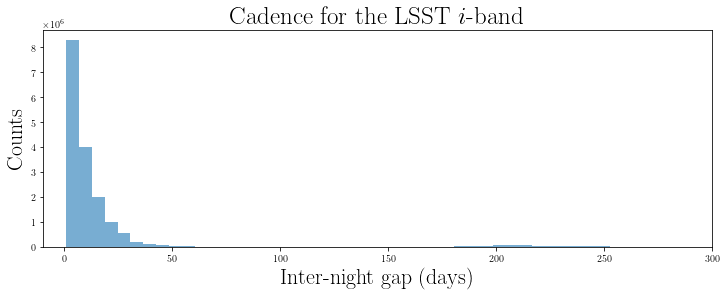

In [3]:
inter_night_gap = lsst.get_inter_night_gap()
print("Median inter-night gap: ", np.median(inter_night_gap))

lsst.plot_inter_night_gap(inter_night_gap)

### Generation of training and test sets


In [12]:
num_samples = 10000           # Total number of lens systems to be generated  
batch_size = 1000             # Number of lens systems that is saved together in a batch
batch = 41                    # Starting number of the batch
num_images = 2                # Choose between 2 (for doubles) and 4 (for quads)
bandpass = 'i'                # Choose between 'r', 'i' or 'z'
obs_upper_limit = 20          # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = False              # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = True       # Bool, if False: Only macro magnification. if True: Add effects of microlensing
Show = False                  # Bool, if True: Show figures and print information about the lens systems
Save = True                   # Bool, if True: Save image time-series
path = "Cadence_microlensing_trainingset_doubles2/"                   # Path to folder in which to save the results


simulate_time_series_images(batch_size, batch,  num_samples, num_images, inter_night_gap, z_source_list_, z_lens_list_, 
                            theta_E_list_, lsst, bandpass, add_microlensing, obs_lower_limit, obs_upper_limit, 
                            fixed_H0, Show, Save, path)


 18%|█▊        | 1775/10000 [3:56:00<15:19:05,  6.70s/it]    

Error with database!
filename:  kappa:0.956_gamma:0.952_s:0.443_zsrc:1.00
kappa =  0.956 , gamma =  0.952 , s =  0.443
source redshift =  1.0


100%|██████████| 10000/10000 [10:35:18<00:00,  2.67s/it] 

Done!
Simulating images took  38119.0 seconds ( 10.59 hours) to complete.
Number of image-time series generated:  10000
Number of configurations tried:  12839
Number of attempts:  1056709
 
                                           time_series  z_source    z_lens  \
0    [[[-3.9388653529181554, 2.3493849080480502, 0....  0.466343  0.050995   
1    [[[-1.2695720745519858, -5.295576751270478, 0....  1.218150  0.815449   
2    [[[9.126193196516803, 1.0451039994501667, -17....  0.907893  0.568328   
3    [[[-9.541949685556387, 0.19515311200009036, 6....  0.661841  0.197188   
4    [[[-3.8884036231993764, 1.4233756183630075, 2....  0.540447  0.160117   
..                                                 ...       ...       ...   
995  [[[-1.1182809497496022, 1.9495350790129722, -4...  0.932238  0.102425   
996  [[[-6.2567380444001515, -13.114878436050219, 4...  0.803987  0.466442   
997  [[[7.58148062522549, 6.811067993015581, -12.82...  0.451728  0.227834   
998  [[[-2.7688082659261033, -

In [5]:
import pandas as pd
import os
import scipy
import scipy.sparse
data_path = 'Cadence_trainingset_doubles/'
start = 0
end = 2
L_limit = 20
N_images = 2
dt_lower_cut = 2
dt_upper_cut = 150
mag_cut = 23.9
size = 10000
param = 'dt'

In [6]:
# -------- Read in data --------
files = sorted([f for f in os.listdir(data_path) if not f.startswith('.') if f.endswith(".pkl")
                if os.path.isfile(os.path.join(data_path, f))],
               key=lambda f: f.lower())[start:end]

df = pd.concat([pd.read_pickle(data_path + x) for x in files], ignore_index=True)

# Drop empty rows (coming from rejected combinations of (z_lens, z_source, theta_E))
time_delay = df['time_delay'].to_numpy()
empty = [ind for ind, x in enumerate(time_delay) if isinstance(x, float)]
df = df.drop(empty)

# Apply cuts
time_delay = df['time_delay'].to_numpy()
peak_brightness_im = df['peak_brightness_im'].to_numpy()
image_x = df['image_x'].to_numpy()
image_y = df['image_y'].to_numpy()

lim_mag = 23.9
x_image, y_image, peak_mags, sep = [], [], [], []
# if N_images == 4:
#    N_visible_images = []
# Make image positions into array to calculate separation
for i in range(len(image_x)):
    x_image.append(np.array(image_x[i]))
    y_image.append(np.array(image_y[i]))
    peak_mags.append(np.array(peak_brightness_im[i]))

    # if N_images == 4:
    #    sep1 = ((x_image[i][0] - x_image[i][1]) ** 2 + (y_image[i][0] - y_image[i][1]) ** 2) ** 0.5
    #    sep2 = ((x_image[i][0] - x_image[i][2]) ** 2 + (y_image[i][0] - y_image[i][2]) ** 2) ** 0.5
    #    sep3 = ((x_image[i][0] - x_image[i][3]) ** 2 + (y_image[i][0] - y_image[i][3]) ** 2) ** 0.5
    #    sep4 = ((x_image[i][1] - x_image[i][2]) ** 2 + (y_image[i][1] - y_image[i][2]) ** 2) ** 0.5
    #    sep5 = ((x_image[i][1] - x_image[i][3]) ** 2 + (y_image[i][1] - y_image[i][3]) ** 2) ** 0.5
    #    sep6 = ((x_image[i][2] - x_image[i][3]) ** 2 + (y_image[i][2] - y_image[i][3]) ** 2) ** 0.5
    #    separations = np.array([sep1, sep2, sep3, sep4, sep5, sep6])
    #    sep.append(max(separations))
    #    N_visible_images.append(len(peak_brightness_im[i][peak_brightness_im < lim_mag]))

x_image = np.array(x_image)
y_image = np.array(y_image)
peak_mags = np.array(peak_mags)
time_delay_1 = np.array([x[-1] for x in time_delay])

if N_images == 2:
    # flux_ratio = 10 ** (peak_mags[:, 1] / -2.5) / 10 ** (peak_mags[:, 0] / -2.5)
    sep = ((x_image[:, 0] - x_image[:, 1]) ** 2 + (y_image[:, 0] - y_image[:, 1]) ** 2) ** 0.5
    peak_im_0 = np.array([x[0] for x in peak_brightness_im])
    peak_im_1 = np.array([x[1] for x in peak_brightness_im])
    indices = (time_delay_1 > dt_lower_cut) & (time_delay_1 < dt_upper_cut) & (peak_im_0 < lim_mag) & \
              (peak_im_1 < mag_cut) & (sep > 0.5) & (sep < 4.0)

elif N_images == 4:
    #sep = np.array(sep)
    #N_visible_images = np.array(N_visible_images)
    #indices = (time_delay_1 > dt_lower_cut) & (time_delay_1 < dt_upper_cut) & (N_visible_images > 2) & \
    #          (sep > 0.5) & (sep < 4.0)
    indices = (time_delay_1 > dt_lower_cut) & (time_delay_1 < dt_upper_cut)


# (To count how many remaining lens systems there are)
print("Total systems: ", len(time_delay), "Remaining after cuts: ", len(time_delay[indices]),
      "Fraction: ", np.around(len(time_delay[indices]) / len(time_delay), 2))

# Reduce the data set to a certain size
N_truth = 0
indices_size = []

for i in range(len(indices)):
    if N_truth < size:
        indices_size.append(indices[i])
    else:
        indices_size.append(False)

    if indices[i]:
        N_truth += 1

# Load all the relevant data properties
data_images = df['time_series'].to_numpy()[indices_size]
data_zlens = df['z_lens'].to_numpy()[indices_size]
data_zsource = df['z_source'].to_numpy()[indices_size]
time_delay_distance = df['time_delay_distance'].to_numpy()[indices_size]
theta_E = df['theta_E'].to_numpy()[indices_size]
gamma = df['gamma_lens'].to_numpy()[indices_size]
H_0 = df['H0'].to_numpy()[indices_size]
source_x = df['source_x'].to_numpy()[indices_size]
source_y = df['source_y'].to_numpy()[indices_size]
image_x = df['image_x'].to_numpy()[indices_size]
image_y = df['image_y'].to_numpy()[indices_size]
peak_brightness_im = df['peak_brightness_im'].to_numpy()[indices_size]
time_delay = df['time_delay'].to_numpy()[indices_size]
e1 = df['e1_lens'].to_numpy()[indices_size]
e2 = df['e2_lens'].to_numpy()[indices_size]
time_stamps = df['time_stamps'].to_numpy()[indices_size]

# -------- Change X_data into numpy arrays  --------

X_data = []
y_data = []
vector_data = []

print("len data_images: ", len(data_images))

# Change into array
for image in range(len(data_images)):

    # ---------- Make vector data into (N, L_limit) dimension ----------

    L = len(time_stamps[image])
    ts_list = list(time_stamps[image])

    # Cut out anything above L_limit observations
    if L > L_limit:
        vector_data.append(np.array(ts_list[:L_limit]))
        # vector_data[image] = vector_data[image][:L_limit]

    # Fill up time_series < L_limit with zero padding
    elif L < L_limit:
        vector_data_temp = ts_list
        for i in range(L_limit - L):
            vector_data_temp.append(0.0)
            # vector_data[image] = np.append(vector_data[image], 0.0)
        vector_data.append(np.array(vector_data_temp))

    else:
        vector_data.append(np.array(ts_list))

    if len(vector_data[image]) != L_limit:
        print("L = ", L)
        if L > L_limit:
            print("if L > L_limit")
        elif L < L_limit:
            print("elif L < L_limit")
        else:
            print("else")
        print("Something went wrong, len(vector_data[image]) is ", len(vector_data[image]))

    # ---------- Apply log transform and unpack sparse layers for X_data ----------

    # Find minimum point for log-transform

    data_images_notsparse = []
    for i in range(len(data_images[image])):
        if not scipy.sparse.issparse(data_images[image][i]):
                data_images_notsparse.append(data_images[image][i])

    a = 1 - np.min(data_images_notsparse)
    X_temp = []

    # Loop through observations
    for obs in range(len(data_images[image])):
        # For a sparse layer: unpack as a dense layer and add to X_temp
        if scipy.sparse.issparse(data_images[image][obs]):
            X_temp.append(np.asarray(data_images[image][obs].todense()).astype(np.float32))
            # X_temp.append(np.zeros((48, 48)))

        # For a dense layer: apply log transform and add to X_temp
        else:
            temp_log = np.log(a + data_images[image][obs])
            # image_max = np.max(temp_log)
            # image_min = np.min(temp_log)
            # temp_scaled = (temp_log - image_min) / (image_max - image_min)
            X_temp.append(np.asarray(temp_log).astype(np.float32))
            # X_temp.append(temp_log)
    
    filler = np.zeros((48, 48))
    
    # If L <= 15: the data arrays are filled with filler layers until a length of 15: just add 5 more
    if L <= 15:
        for i in range(5):
            X_temp.append(filler)
        
    # If L > 15 and < L_limit: they need to be filled until the length of the array reaches L_limit
    if 15 < L < L_limit:
        for i in range(L_limit - L):
            X_temp.append(filler)

    X_data.append(np.array(X_temp))

    if param == 'dt' and N_images == 2:
        y_data.append(time_delay[image][-1])
    elif param == 'dt' and N_images == 4:
        y_data.append(np.array([time_delay[image][1], time_delay[image][2], time_delay[image][3]]))
    elif param == 'Ddt' and N_images == 4:
        y_data.append(time_delay_distance[image])
    elif param == 'e1e2':
        y_data.append(np.array([e1[image], e2[image]]))
    elif param == 'im' and N_images == 2:
        y_data.append(np.array([image_x[image][0], image_y[image][0], image_x[image][1], image_y[image][1]]))
    elif param == 'im' and N_images == 4:
        y_data.append(np.array([image_x[image][0], image_y[image][0], image_x[image][1], image_y[image][1],
                                image_x[image][2], image_y[image][2], image_x[image][3], image_y[image][3]]))
    elif param == 'source':
        y_data.append(np.array([source_x[image], source_y[image]]))
    elif param == 'thetaE':
        y_data.append(theta_E[image])
    elif param == 'gamma':
        y_data.append(gamma[image])

X_data = np.array(X_data)
print(np.shape(X_data))

vector_data = np.array(vector_data)
print(np.shape(vector_data))
X_data = np.transpose(X_data, (0, 2, 3, 1))
X_data = np.reshape(X_data, [len(data_images), 48, 48, L_limit, 1])
y_data = np.array(y_data)

print("Shape X_data: ", np.shape(X_data))
print("Shape y_data: ", np.shape(y_data))
print("Shape vector_data: ", np.shape(vector_data))

100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Total systems:  2000 Remaining after cuts:  1870 Fraction:  0.94
len data_images:  1870
(1870, 20, 48, 48)
(1870, 20)
Shape X_data:  (1870, 48, 48, 20, 1)
Shape y_data:  (1870,)
Shape vector_data:  (1870, 20)
